In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from sdv.single_table import CTGANSynthesizer
from sdv.sampling import Condition

In [2]:
df = pd.read_csv('../../data/Angoss Knowledge Seeker - carclaims.txt/carclaims_original.csv')

df.drop(df[df['DayOfWeekClaimed'] == '0'].index, inplace=True)
df.drop(columns='PolicyNumber', inplace=True)

carclaims_train, carclaims_test = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
carclaims_test

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
9454,Feb,3,Wednesday,Accura,Urban,Monday,Dec,1,Male,Married,49,Policy Holder,Utility - All Perils,Utility,"more than 69,000",10,400,4,more than 30,more than 30,more than 4,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1995,All Perils,No
7874,Jun,3,Wednesday,Toyota,Urban,Tuesday,Jul,3,Female,Married,52,Policy Holder,Sedan - Liability,Sport,"20,000 to 29,000",2,400,2,more than 30,more than 30,none,6 years,41 to 50,No,No,External,none,no change,1 vehicle,1995,Liability,No
10858,Apr,4,Sunday,Toyota,Rural,Thursday,Apr,5,Male,Single,21,Policy Holder,Sedan - All Perils,Sedan,"20,000 to 29,000",12,400,4,more than 30,more than 30,none,5 years,26 to 30,No,No,External,none,no change,1 vehicle,1995,All Perils,No
12930,Jun,2,Monday,Nisson,Urban,Monday,Jun,2,Male,Married,52,Third Party,Sedan - All Perils,Sedan,"more than 69,000",7,400,2,more than 30,more than 30,2 to 4,more than 7,41 to 50,No,No,External,more than 5,no change,1 vehicle,1996,All Perils,No
13083,Aug,2,Sunday,Honda,Urban,Monday,Sep,4,Male,Single,24,Policy Holder,Sedan - Liability,Sport,"20,000 to 29,000",1,400,1,more than 30,more than 30,2 to 4,5 years,26 to 30,No,No,External,none,4 to 8 years,2 vehicles,1996,Liability,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8728,Jan,4,Saturday,Chevrolet,Urban,Monday,Jan,4,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,"20,000 to 29,000",9,400,3,more than 30,more than 30,none,7 years,36 to 40,No,No,External,none,no change,1 vehicle,1995,Collision,No
3777,May,3,Wednesday,Toyota,Urban,Friday,May,3,Male,Married,55,Policy Holder,Sedan - Collision,Sedan,"more than 69,000",14,400,4,more than 30,more than 30,1,more than 7,41 to 50,No,No,External,more than 5,no change,1 vehicle,1994,Collision,Yes
5438,Sep,4,Monday,Saab,Urban,Tuesday,Oct,1,Male,Married,48,Third Party,Sedan - All Perils,Sedan,"30,000 to 39,000",4,400,4,more than 30,more than 30,none,more than 7,41 to 50,No,No,External,1 to 2,no change,1 vehicle,1994,All Perils,No
5164,Oct,3,Saturday,Toyota,Urban,Wednesday,Oct,4,Male,Married,41,Third Party,Sedan - Collision,Sedan,"20,000 to 29,000",11,400,4,more than 30,more than 30,2 to 4,7 years,36 to 40,No,No,External,3 to 5,no change,1 vehicle,1994,Collision,No


In [ ]:
from sdv.metadata import Metadata

# 1. auto-detect metadata based in your data
metadata = Metadata.detect_from_dataframes(
    data={
        'carclaims': carclaims_train
    })

# 2. carefully inspect and update your metadata
# Does not work in WSL, needs to be investigated further
metadata.visualize()

metadata.validate()

# 3. when you're done, save it to a file for future use
metadata.save_to_json('carclaims_metadata.json')

/home/abdussaboor/.virtualenvs/mlr503-project/lib/python3.12/site-packages/sdv/metadata/visualization.py:118: RuntimeWarning: Graphviz does not seem to be installed on this system. For full metadata visualization capabilities, please make sure to have its binaries propertly installed: https://graphviz.gitlab.io/download/
  warnings.warn(warning_message, RuntimeWarning)


In [5]:
synthesizer = CTGANSynthesizer(metadata)
synthesizer.fit(carclaims_train)

/home/abdussaboor/.virtualenvs/mlr503-project/lib/python3.12/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [8]:
fraud_samples = Condition(
    num_rows=500_000,
    column_values={'FraudFound': 'Yes'}
)

non_fraud_samples = Condition(
    num_rows=500_000,
    column_values={'FraudFound': 'No'}
)

synthetic_data = synthesizer.sample_from_conditions(
    conditions=[fraud_samples, non_fraud_samples],
    batch_size=1_000
)

Sampling conditions: 100%|██████████| 1000000/1000000 [10:13<00:00, 1629.32it/s]


In [9]:
X_train = synthetic_data.drop('FraudFound', axis=1).reset_index(drop=True)
y_train = synthetic_data['FraudFound'].reset_index(drop=True)

X_test = carclaims_test.drop('FraudFound', axis=1).reset_index(drop=True)
y_test = carclaims_test['FraudFound'].reset_index(drop=True)

In [10]:
y_test

0        No
1        No
2        No
3        No
4        No
       ... 
3079     No
3080    Yes
3081     No
3082     No
3083     No
Name: FraudFound, Length: 3084, dtype: object

In [11]:
# Encode target variable
y_train.loc[y_train[:] == 'No'] = 0
y_train.loc[y_train[:] == 'Yes'] = 1

y_test.loc[y_test[:] == 'No'] = 0
y_test.loc[y_test[:] == 'Yes'] = 1

y_train = y_train.astype(int)
y_test = y_test.astype(int)



In [12]:
column_labels = {
    'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'DayOfWeek': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    'DayOfWeekClaimed': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    'MonthClaimed': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'AgeOfPolicyHolder': ['16 to 17', '18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 50', '51 to 65', 'over 65'],
    'NumberOfSuppliments': ['none', '1 to 2', '3 to 5', 'more than 5'],
    'AddressChange-Claim': ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years'],
    'NumberOfCars': ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8'],
    'VehiclePrice': ['less than 20,000', '20,000 to 29,000', '30,000 to 39,000', '40,000 to 59,000', '60,000 to 69,000', 'more than 69,000'],
    'Days:Policy-Accident': ['none', '1 to 7', '15 to 30', '8 to 15', 'more than 30'],
    'Days:Policy-Claim': ['15 to 30', '8 to 15', 'more than 30'],
    'PastNumberOfClaims': ['none', '1', '2 to 4', 'more than 4'],
    'AgeOfVehicle': ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7'],
    'Make': ['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW']
}

In [13]:
for column, labels in column_labels.items():
    oe = OrdinalEncoder(categories=[labels], handle_unknown='use_encoded_value', unknown_value=-1)
    # oe.fit(labels)
    X_train[column] = oe.fit_transform(X_train[column].values.reshape(-1, 1))
    X_test[column] = oe.transform(X_test[column].values.reshape(-1, 1))

In [14]:
X_test

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy
0,1.0,3,2.0,0.0,Urban,0.0,11.0,1,Male,Married,49,Policy Holder,Utility - All Perils,Utility,5.0,10,400,4,4.0,2.0,3.0,6.0,6.0,No,No,External,0.0,0.0,0.0,1995,All Perils
1,5.0,3,2.0,17.0,Urban,1.0,6.0,3,Female,Married,52,Policy Holder,Sedan - Liability,Sport,1.0,2,400,2,4.0,2.0,0.0,5.0,6.0,No,No,External,0.0,0.0,0.0,1995,Liability
2,3.0,4,6.0,17.0,Rural,3.0,3.0,5,Male,Single,21,Policy Holder,Sedan - All Perils,Sedan,1.0,12,400,4,4.0,2.0,0.0,4.0,3.0,No,No,External,0.0,0.0,0.0,1995,All Perils
3,5.0,2,0.0,12.0,Urban,0.0,5.0,2,Male,Married,52,Third Party,Sedan - All Perils,Sedan,5.0,7,400,2,4.0,2.0,2.0,7.0,6.0,No,No,External,3.0,0.0,0.0,1996,All Perils
4,7.0,2,6.0,6.0,Urban,0.0,8.0,4,Male,Single,24,Policy Holder,Sedan - Liability,Sport,1.0,1,400,1,4.0,2.0,2.0,4.0,3.0,No,No,External,0.0,4.0,1.0,1996,Liability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,0.0,4,5.0,2.0,Urban,0.0,0.0,4,Male,Married,45,Policy Holder,Sedan - Collision,Sedan,1.0,9,400,3,4.0,2.0,0.0,6.0,5.0,No,No,External,0.0,0.0,0.0,1995,Collision
3080,4.0,3,2.0,17.0,Urban,4.0,4.0,3,Male,Married,55,Policy Holder,Sedan - Collision,Sedan,5.0,14,400,4,4.0,2.0,1.0,7.0,6.0,No,No,External,3.0,0.0,0.0,1994,Collision
3081,8.0,4,0.0,15.0,Urban,1.0,9.0,1,Male,Married,48,Third Party,Sedan - All Perils,Sedan,2.0,4,400,4,4.0,2.0,0.0,7.0,6.0,No,No,External,1.0,0.0,0.0,1994,All Perils
3082,9.0,3,5.0,17.0,Urban,2.0,9.0,4,Male,Married,41,Third Party,Sedan - Collision,Sedan,1.0,11,400,4,4.0,2.0,2.0,6.0,5.0,No,No,External,2.0,0.0,0.0,1994,Collision


In [15]:
# columns_one_hot = ['AccidentArea', 'Sex', 'MaritalStatus', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'BasePolicy', 'Fault', 'PolicyType', 'VehicleCategory']
columns_one_hot = {
    'AccidentArea': ['Rural', 'Urban'],
    'Sex': ['Female', 'Male'],
    'MaritalStatus': ['Divorced', 'Married', 'Single', 'Widow'],
    'PoliceReportFiled': ['No', 'Yes'],
    'WitnessPresent': ['No', 'Yes'],
    'AgentType': ['External', 'Internal'],
    'BasePolicy': ['All Perils', 'Collision', 'Liability'],
    'Fault': ['Policy Holder', 'Third Party'],
    'PolicyType': ['Sedan - All Perils', 'Sedan - Collision', 'Sedan - Liability','Sport - All Perils', 'Sport - Collision', 'Sport - Liability', 'Utility - All Perils', 'Utility - Collision', 'Utility - Liability'],
    'VehicleCategory': ['Sedan', 'Sport', 'Utility']
}

In [16]:

for column, labels in columns_one_hot.items():
    ohe = OneHotEncoder(sparse_output=False, categories=[labels], drop='first', handle_unknown='error')
    encoded_nominal = ohe.fit_transform(X_train[[column]])
    X_train = pd.concat([X_train, pd.DataFrame(encoded_nominal, columns=ohe.get_feature_names_out([column]))], axis=1)#, ignore_index=True)
    
    encoded_nominal = ohe.transform(X_test[[column]])
    X_test = pd.concat([X_test, pd.DataFrame(encoded_nominal, columns=ohe.get_feature_names_out([column]))], axis=1)#, ignore_index=True)
    
X_test.drop(columns=columns_one_hot.keys(), axis=1, inplace=True)
X_train.drop(columns=columns_one_hot.keys(), axis=1, inplace=True)

In [17]:
X_test.shape

(3084, 42)

In [18]:
X_test

,Month,WeekOfMonth,DayOfWeek,Make,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Age,VehiclePrice,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,AccidentArea_Urban,Sex_Male,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PoliceReportFiled_Yes,WitnessPresent_Yes,AgentType_Internal,BasePolicy_Collision,BasePolicy_Liability,Fault_Third Party,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sport,VehicleCategory_Utility
0,1.0,3,2.0,0.0,0.0,11.0,1,49,5.0,10,400,4,4.0,2.0,3.0,6.0,6.0,0.0,0.0,0.0,1995,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,5.0,3,2.0,17.0,1.0,6.0,3,52,1.0,2,400,2,4.0,2.0,0.0,5.0,6.0,0.0,0.0,0.0,1995,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.0,4,6.0,17.0,3.0,3.0,5,21,1.0,12,400,4,4.0,2.0,0.0,4.0,3.0,0.0,0.0,0.0,1995,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.0,2,0.0,12.0,0.0,5.0,2,52,5.0,7,400,2,4.0,2.0,2.0,7.0,6.0,3.0,0.0,0.0,1996,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.0,2,6.0,6.0,0.0,8.0,4,24,1.0,1,400,1,4.0,2.0,2.0,4.0,3.0,0.0,4.0,1.0,1996,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,0.0,4,5.0,2.0,0.0,0.0,4,45,1.0,9,400,3,4.0,2.0,0.0,6.0,5.0,0.0,0.0,0.0,1995,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3080,4.0,3,2.0,17.0,4.0,4.0,3,55,5.0,14,400,4,4.0,2.0,1.0,7.0,6.0,3.0,0.0,0.0,1994,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3081,8.0,4,0.0,15.0,1.0,9.0,1,48,2.0,4,400,4,4.0,2.0,0.0,7.0,6.0,1.0,0.0,0.0,1994,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3082,9.0,3,5.0,17.0,2.0,9.0,4,41,1.0,11,400,4,4.0,2.0,2.0,6.0,5.0,2.0,0.0,0.0,1994,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/home/abdussaboor/.virtualenvs/mlr503-project/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:19:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost on SMOTE + Autoencoder Processed Data ===
Accuracy: 0.5519
Precision: 0.0878
Recall: 0.6332
F1 Score: 0.1542


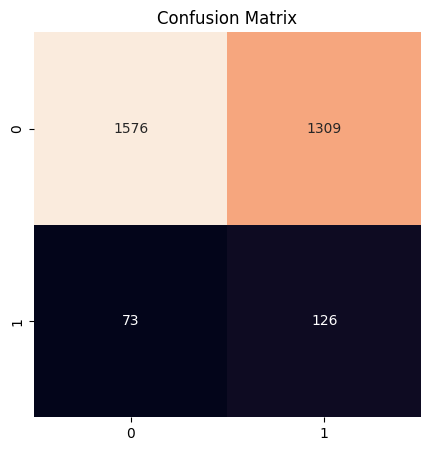

: 

In [ ]:
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',    
    random_state=42
)

xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# print("\n=== XGBoost on SMOTE + Autoencoder Processed Data ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
def conf_matrix(y_test, y_pred):
    con_matrix = confusion_matrix(y_test, y_pred)
    con_matrix = pd.DataFrame(con_matrix, range(2), range(2))
    plt.figure(figsize=(5, 5))
    plt.title("Confusion Matrix")
    sns.heatmap(con_matrix, annot=True, cbar=False, fmt='g')

conf_matrix(y_test, y_pred)

In [ ]:
# # Apply SMOTE to balance the dataset
# smote = SMOTE(random_state=42)
# X_smote, y_smote = smote.fit_resample(X_train, y_train)

# print("Before SMOTE:")
# print(f"Class distribution: {Counter(y_train)}")
# print("After SMOTE:")
# print(f"Class distribution: {Counter(y_smote)}")

# # Shuffle SMOTE-generated data
# X_smote, y_smote = shuffle(X_smote, y_smote, random_state=42)

# # Define Autoencoder
# input_dim = X_smote.shape[1]
# encoding_dim = 16  # Latent space dimension

# # Encoder
# input_layer = Input(shape=(input_dim,))
# encoded = Dense(64, activation='relu')(input_layer)
# encoded = Dense(32, activation='relu')(encoded)
# latent = Dense(encoding_dim, activation='relu')(encoded)

# # Decoder
# decoded = Dense(32, activation='relu')(latent)
# decoded = Dense(64, activation='relu')(decoded)
# output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# # Autoencoder model
# autoencoder = Model(inputs=input_layer, outputs=output_layer)
# autoencoder.compile(optimizer='adam', loss='mse')

# # Train autoencoder on SMOTE data
# autoencoder.fit(X_smote, X_smote, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# # Extract latent representations
# encoder = Model(inputs=autoencoder.input, outputs=latent)
# X_latent = encoder.predict(X_smote)

# # Split latent data into training and testing sets
# X_train_latent, X_test_latent, y_train_latent, y_test_latent = train_test_split(
#     X_latent, y_smote, test_size=0.2, stratify=y_smote, random_state=42
# )

# # Train XGBoost Classifier on Latent Space
# xgb_clf = XGBClassifier(
#     use_label_encoder=False,  # Disable the deprecation warning
#     eval_metric='logloss',   # Set evaluation metric
#     random_state=42
# )
# xgb_clf.fit(X_train_latent, y_train_latent)

# # Make predictions
# y_pred_latent = xgb_clf.predict(X_test_latent)

# # Evaluate the model
# accuracy = accuracy_score(y_test_latent, y_pred_latent)
# precision = precision_score(y_test_latent, y_pred_latent)
# recall = recall_score(y_test_latent, y_pred_latent)
# f1 = f1_score(y_test_latent, y_pred_latent)

# print("\n=== XGBoost on SMOTE + Autoencoder Processed Data ===")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")

# # Confusion Matrix
# def conf_matrix(y_test, y_pred):
#     con_matrix = confusion_matrix(y_test, y_pred)
#     con_matrix = pd.DataFrame(con_matrix, range(2), range(2))
#     plt.figure(figsize=(5, 5))
#     plt.title("Confusion Matrix")
#     sns.heatmap(con_matrix, annot=True, cbar=False, fmt='g')

# conf_matrix(y_test_latent, y_pred_latent)

Before SMOTE:
Class distribution: Counter({0: 957017, 1: 42983})
After SMOTE:
Class distribution: Counter({0: 957017, 1: 957017})


NameError: name 'Input' is not defined

In [84]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [85]:
import keras
import tensorflow as tf
print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")

Keras version: 3.6.0
TensorFlow version: 2.18.0


In [30]:
X_test

,Month,WeekOfMonth,DayOfWeek,Make,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Age,VehiclePrice,RepNumber,...,Fault_Third Party,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sport,VehicleCategory_Utility
9454,1.0,3.0,2.0,0.0,0.0,11.0,1.0,49.0,5.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7874,5.0,3.0,2.0,17.0,1.0,6.0,3.0,52.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10858,3.0,4.0,6.0,17.0,3.0,3.0,5.0,21.0,1.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12930,5.0,2.0,0.0,12.0,0.0,5.0,2.0,52.0,5.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13083,7.0,2.0,6.0,6.0,0.0,8.0,4.0,24.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
y_test

9454     0
7874     0
10858    0
12930    0
13083    0
        ..
8728     0
3777     1
5438     0
5164     0
1944     0
Name: FraudFound, Length: 3084, dtype: int64